In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from interpret.chefer import *
from models.st_transformer import *
from models.pytorch_lightning import *
from data import *
from interpret.visualize import *

In [2]:
class_labels = {
    0 : 'Seizure', 1 : 'LPD', 2 : 'GPD', 3 : 'LRDA', 4: 'GRDA', 5 :'Other'
}

In [3]:
# load the dataset

train_loader, test_loader, val_loader, cal_loader = prepare_IIIC_cal_dataloader(drop_last=True)
train = train_loader.dataset
test = test_loader.dataset

107560 13445 35740 13445
210 26 69 26


In [4]:

# # compute percentage of "5" class
# counter = 0
# for i in range(len(train)):
#     signal, label = train[i]
#     if label == 5:
#         counter+=1
        

# print(counter/len(train))

In [5]:
print(len(test))

35740


LRDA
torch.Size([1, 16, 2000])


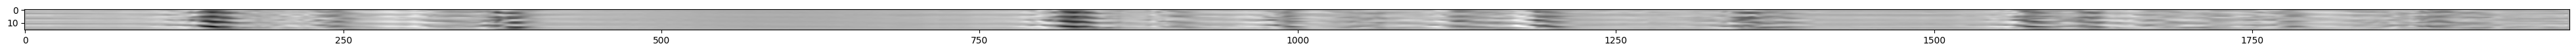

In [6]:
# visualize one example
index = 3120
signal, label = test[index]
signal = signal.unsqueeze(0) # assume batch dim
plt.figure(figsize=(50,50))
# do first 200 to make figure less hard to see.
plt.imshow(signal[:,:,:].squeeze().numpy(), cmap='gray')
plt.savefig(f"fig/int/IIIC_ex{index}.png")
print(class_labels[label])
print(signal.size())

In [7]:
# load the model
# model = STTransformer(depth=4, n_classes=6, channel_length=1000, dropout=0.5)
 # my model hyperparameters
emb_size = 256
depth = 6 
dropout = 0.5
num_heads = 8
patch_kernel_length = 11  # cqi = 15 - UNUSED
stride = 11  # cqi = 8 - UNUSED

model = STTransformer(emb_size=emb_size, 
                                depth=depth,
                                n_classes=6, 
                                channel_length=2000,
                                dropout=dropout, 
                                num_heads=num_heads,
                                kernel_size=11, 
                                stride=11,
                                kernel_size2=11,
                                stride2=11)

model.load_state_dict(torch.load("saved_weights/st_transformer_conformal_IIIC.pt"))


<All keys matched successfully>

In [8]:
# get visualization
model(signal).size()

print(model.channel_attention.get_attn_map().size()) # 1. Can we ignore channel attention? Probably no, because we want to highlight those areas highlighted by channel attention too
print(model.transformer.transformer_blocks[0].mhattn.get_attn_map().size()) # 2. Can we do this first? Yes

torch.Size([1, 16, 16])
torch.Size([1, 8, 21, 21])


Cuda Enabled!
Top 5 Scores in Increasing Order
Class LRDA with score: 22.127180099487305
Class Seizure with score: 3.1835384368896484
Class LPD with score: 1.567145824432373
Class GPD with score: -3.9423019886016846
Class Other with score: -4.843146800994873
True Label: LRDA


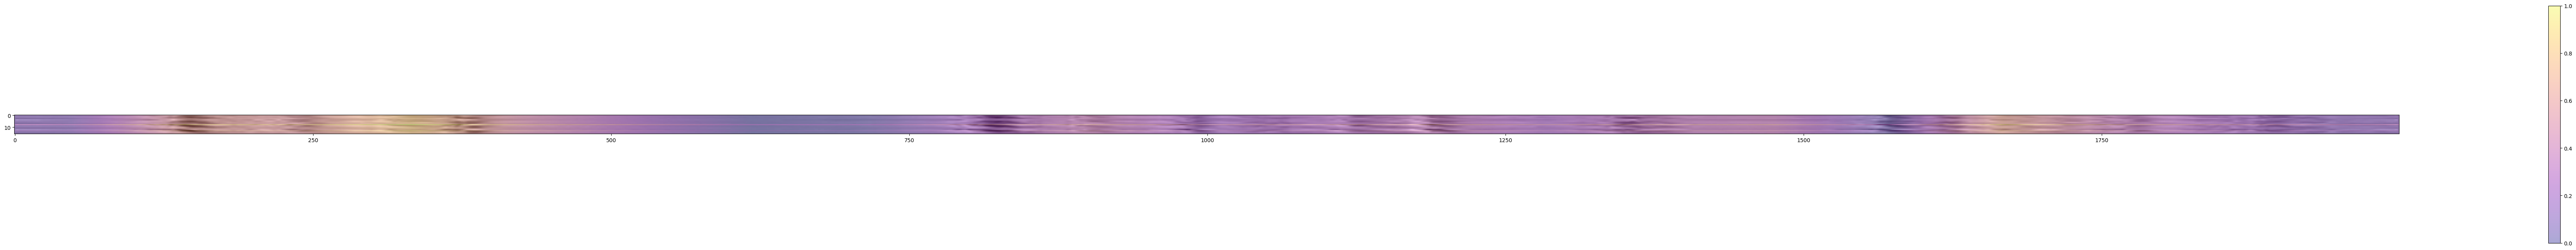

In [9]:
interpreter = STTransformerInterpreter(model=model)
sequence, attribution = interpreter.visualize(signal, class_index = None, save_path="fig/IIIC_seq_highlighted.png", figsize=(100,16), method="linear")
# plt.imshow(vis)
interpreter.get_top_classes(signal, class_labels=class_labels)
print("True Label:", class_labels[label])

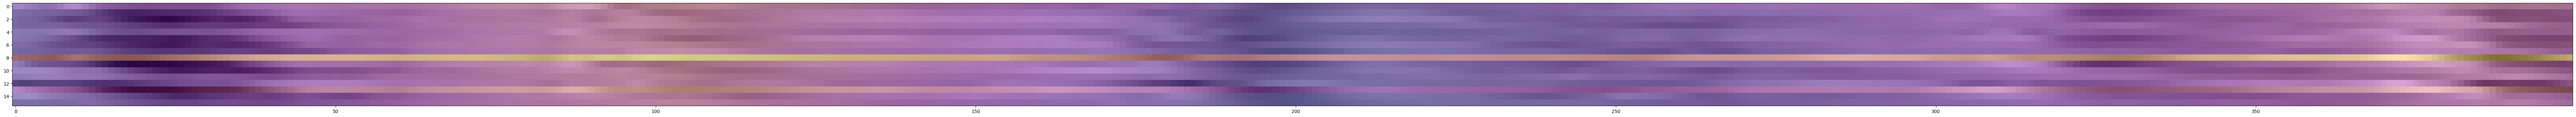

In [10]:
# zooming in on a specific section
start = 800
end = 1200
plt.figure(figsize=(100, 32))
plt.imshow(sequence[:,start:end], cmap='gray')
plt.imshow(attribution[:,start:end], alpha=0.4, cmap='plasma')

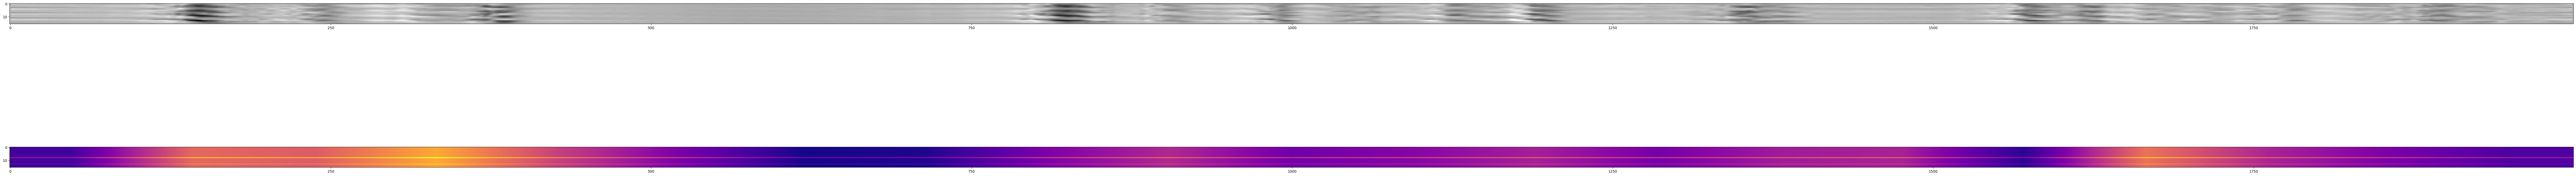

In [11]:
# zoom in on the highlighted features
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(100,16))  # 1 row, 2 columns of subplots


ax1.imshow(sequence, cmap='gray')
ax2.imshow(attribution, cmap='plasma')
plt.tight_layout()
# plt.subplot_tool()
plt.savefig("fig/IIIC_sequence_and_rel_map.png")

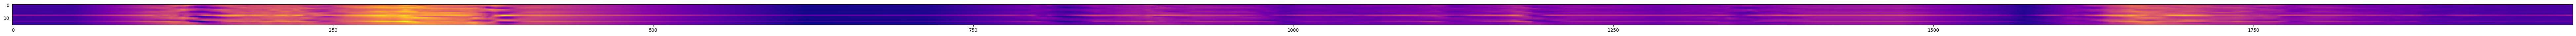

In [12]:
plt.figure(figsize=(100,16))
plt.imshow(sequence * attribution, cmap="plasma")
plt.savefig("fig/IIIC_cam.png")

Zoooming in on the really important stuff.

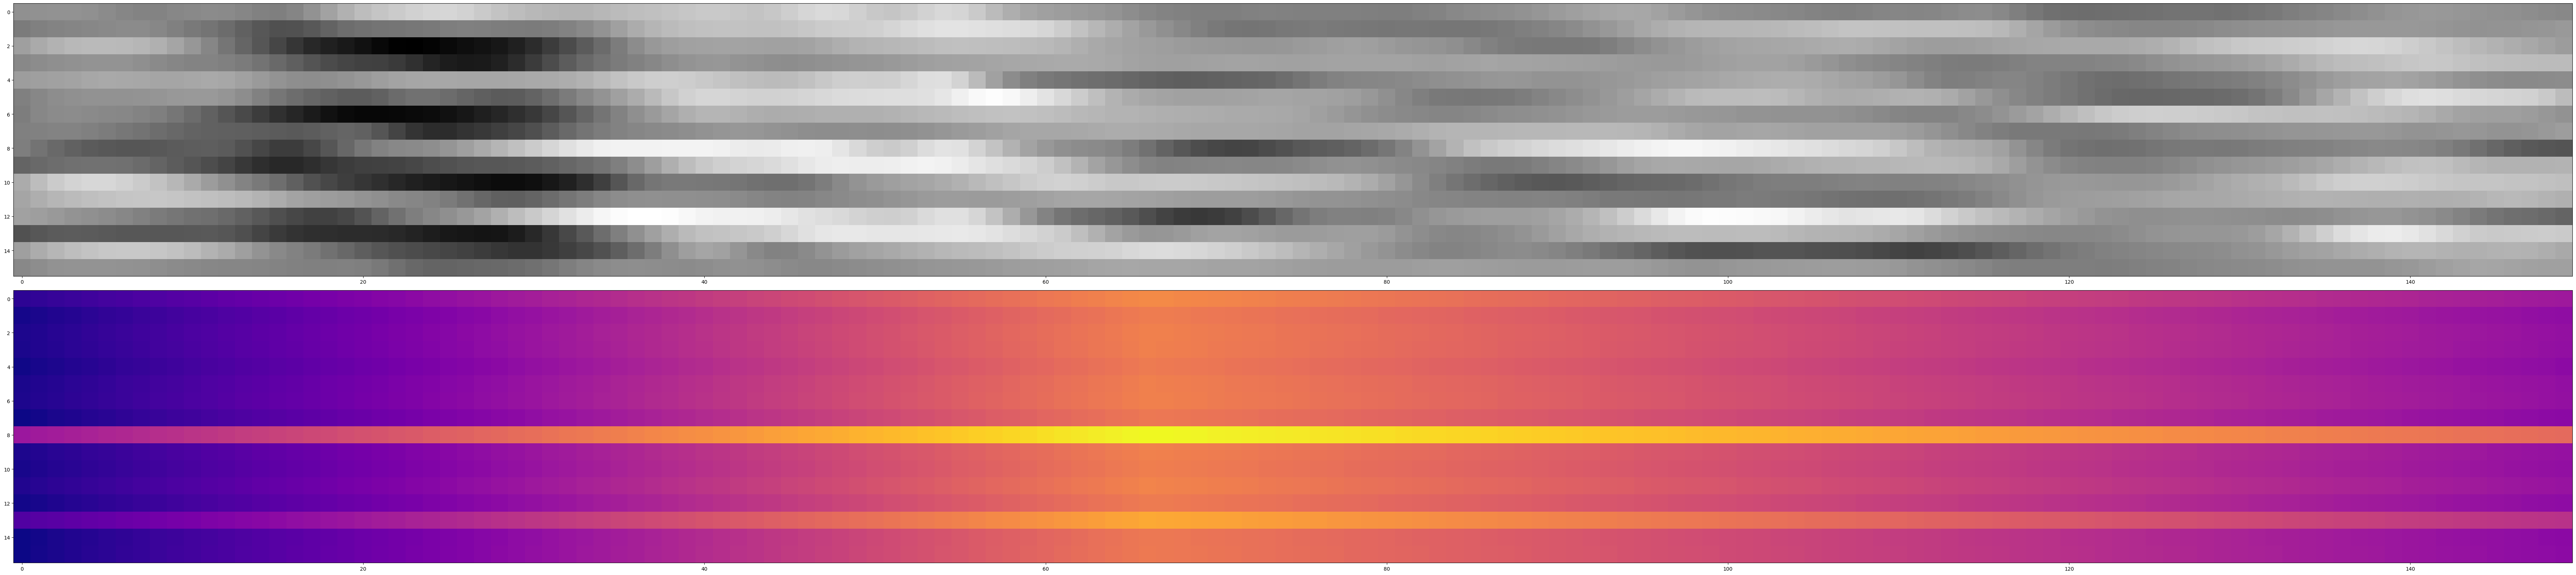

In [13]:
# zoom in on the highlighted features
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(100,16))  # 1 row, 2 columns of subplots


ax1.imshow(sequence[:,1600:1750], cmap='gray')
ax2.imshow(attribution[:,1600:1750], cmap='plasma')
plt.tight_layout()
# plt.subplot_tool()
plt.savefig("fig/IIIC_sequence_and_rel_map_zoomed.png")

[8 8 8 ... 8 8 8]


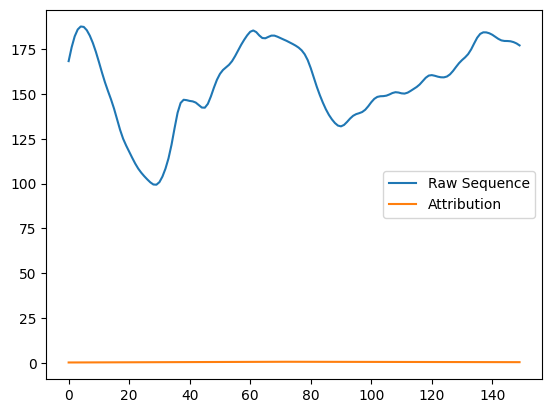

In [14]:
# map out explicitly which is the max channel and, then plot it out in 1D
print(np.argmax(attribution, axis=0))
plt.plot(sequence[10, 1600:1750], label="Raw Sequence")
plt.plot(attribution[10, 1600:1750], label="Attribution")
plt.legend()

In [15]:
## Get average per class seizure
class_index = 0 
n_seizures = 0
seizure_signals = []
avg_tensor = torch.zeros((16, 2000))
for i in range(len(test)):
    signal, label = test[i]
    if label == class_index:
        n_seizures+=1
        avg_tensor+=signal 
        seizure_signals.append(signal)
avg_tensor /= n_seizures


In [16]:
# sequence, attribution = interpreter.visualize(signal, class_index = None, show=False, figsize=(100,16), method="linear")
# plt.imshow(vis)
# signal = torch.from_numpy(seizure_signals[5]).unsqueeze(0)
interpreter.get_top_classes(signal.unsqueeze(0), class_labels=class_labels)

Top 5 Scores in Increasing Order
Class Seizure with score: 8.050566673278809
Class GPD with score: 3.4429566860198975
Class GRDA with score: -2.648529291152954
Class LPD with score: -3.2655189037323
Class LRDA with score: -10.734760284423828


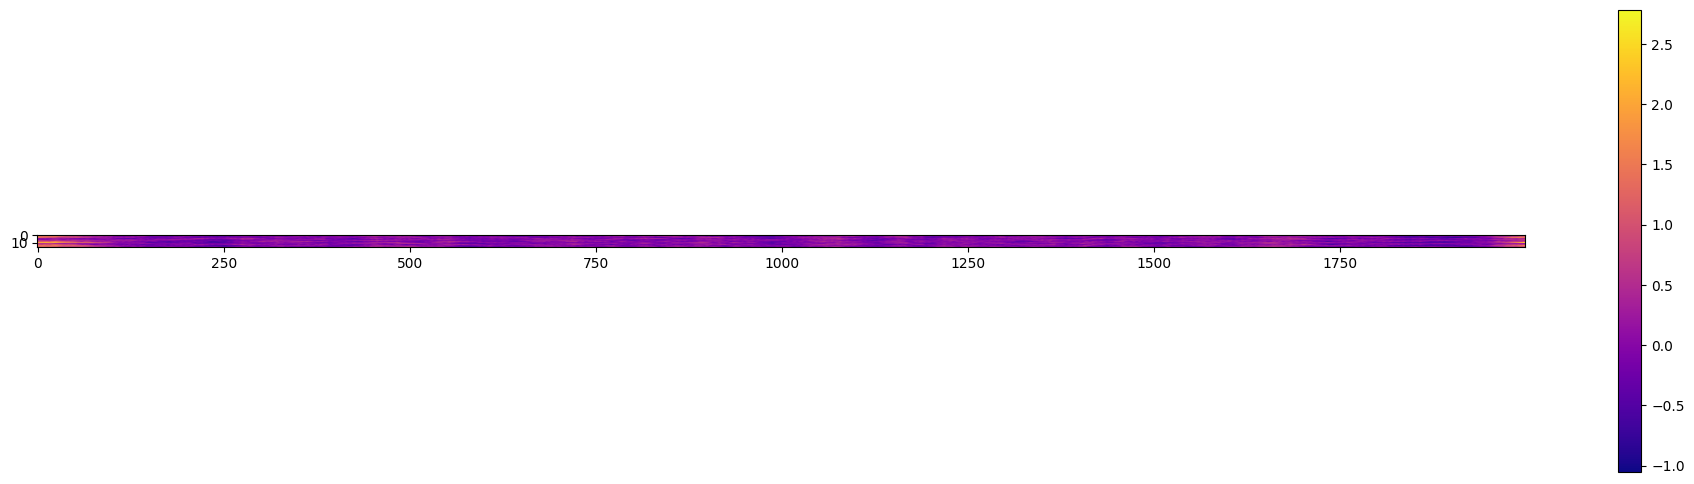

In [17]:
plt.figure(figsize=(24,6))
plt.imshow(avg_tensor, cmap='plasma')
plt.savefig("fig/int/IIIC/average_seizure_signal.png" , bbox_inches='tight', pad_inches=0.0)
plt.colorbar()

In [18]:
print(n_seizures)
print(len(seizure_signals))
print(avg_tensor)
print(torch.max(avg_tensor))

6852
6852
tensor([[0.4617, 0.5524, 0.5054,  ..., 0.2792, 0.2624, 0.0062],
        [0.3378, 0.7251, 0.7945,  ..., 1.4614, 1.1874, 0.2508],
        [0.8684, 2.0234, 2.3683,  ..., 1.0764, 0.9372, 0.2664],
        ...,
        [0.5395, 0.9903, 1.0257,  ..., 1.7538, 1.4989, 0.2669],
        [0.7089, 1.9646, 2.0124,  ..., 1.5758, 1.3875, 0.3656],
        [0.6601, 1.0170, 1.0314,  ..., 0.9028, 0.8124, 0.1349]])
tensor(2.7835)


In [19]:
cat = torch.stack(seizure_signals,dim=0)
print(cat.size())

# go through batches manually to get the average because y not
# for i in range(cat.size()[0]):


torch.Size([6852, 16, 2000])


In [20]:
cams = []
start  = 0
end = 500
while (end < cat.size()[0] - 500):
    
    cams.append(interpreter.get_cam(cat[start:end], class_index=0))
    start+=500
    end+=500



In [21]:
cams  = torch.cat(cams, dim=0)
print(cams.size())


torch.Size([6000, 16, 2000])


In [24]:
to_vis_signals = cat.cpu().numpy()
to_vis_cams = cams.cpu().numpy()
visualize_dataset(signals=to_vis_signals, cams=to_vis_cams)

interactive(children=(IntSlider(value=0, description='Class Index', max=5999), Output()), _dom_classes=('widge…

torch.Size([16, 2000])


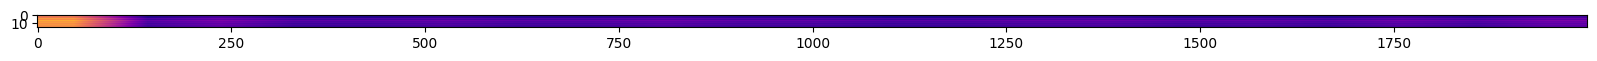

In [ ]:
mean = cams.mean(0)
print(mean.size())
plt.figure(figsize=(20,20))
plt.imshow(mean.cpu().numpy(), cmap='plasma')

In [ ]:
average_mask = torch.zeros((16,2000))
masks = []
for seizure_signal in seizure_signals:
    seizure_signal = seizure_signal.unsqueeze(0)
    norm_signal, saliency_map = interpreter.visualize(sequence=seizure_signal, class_index=class_index, method="linear", show=False)
    average_mask += saliency_map 
    masks.append(saliency_map)
average_mask /= n_seizures
masks = np.array(masks)
# np.save("interpret/IIIC/seizure_masks/masks_linear.npy", masks)
print(masks.shape)

Returned Multiple Normalized Sequences and Transformer Attributions
Returned Multiple Normalized Sequences and Transformer Attributions
Returned Multiple Normalized Sequences and Transformer Attributions
Returned Multiple Normalized Sequences and Transformer Attributions
Returned Multiple Normalized Sequences and Transformer Attributions
Returned Multiple Normalized Sequences and Transformer Attributions
Returned Multiple Normalized Sequences and Transformer Attributions
Returned Multiple Normalized Sequences and Transformer Attributions
Returned Multiple Normalized Sequences and Transformer Attributions
Returned Multiple Normalized Sequences and Transformer Attributions
Returned Multiple Normalized Sequences and Transformer Attributions
Returned Multiple Normalized Sequences and Transformer Attributions
Returned Multiple Normalized Sequences and Transformer Attributions
Returned Multiple Normalized Sequences and Transformer Attributions
Returned Multiple Normalized Sequences and Trans

KeyboardInterrupt: 

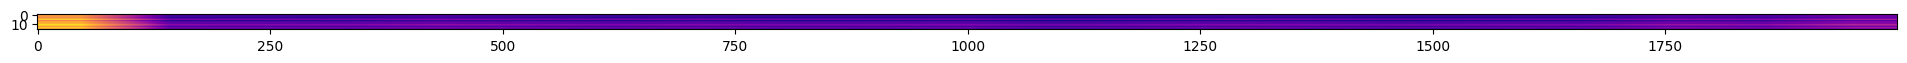

In [ ]:
plt.figure(figsize=(24,6))
plt.imshow(average_mask,cmap='plasma')
# plt.colorbar()
plt.savefig("fig/int/IIIC/average_lin_mask_seizure.png", bbox_inches='tight', pad_inches=0.0)


In [ ]:
# compute variances of signals and masks
seizure_signals = np.array(seizure_signals)
print(seizure_signals.shape)
print(masks.shape)

(6852, 16, 2000)
(6852, 16, 2000)


In [ ]:
var_masks = np.var(masks, axis=0)
var_signal = np.var(seizure_signals, axis=0)

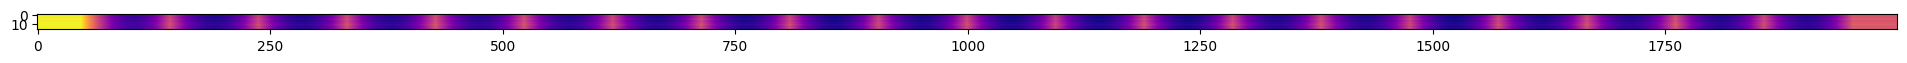

In [ ]:
plt.figure(figsize=(24,6))
plt.imshow(var_masks, cmap='plasma')
# plt.colorbar()
plt.savefig("fig/int/IIIC/var_lin_mask_seizure.png", bbox_inches='tight', pad_inches=0.0)

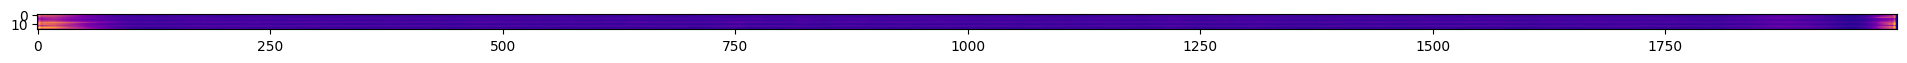

In [ ]:
plt.figure(figsize=(24,6))
plt.imshow(var_signal, cmap='plasma')
plt.savefig("fig/int/IIIC/var_signal.png", bbox_inches='tight', pad_inches=0.0)

In [ ]:
print(np.argmax(avg_tensor, axis=0))
print(np.median(np.argmax(avg_tensor, axis=0)))

tensor([ 9,  9,  2,  ..., 10, 10,  3])
7.0


In [ ]:
print(np.argmax(average_mask, axis=0))
print(np.median(np.argmax(average_mask, axis=0)))

tensor([5, 5, 5,  ..., 5, 5, 5])
5.0


tensor(0.)
tensor(1.)


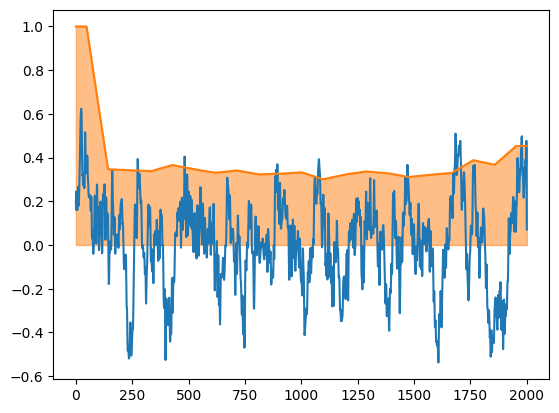

In [ ]:
t = np.linspace(0, 2000, 2000)
categorical = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
# print(t.shape)
# plt.plot()
channel_index = 5
plt.plot(t, avg_tensor[channel_index,:], c=categorical[0]) # bad name, tensor is the signal we care about
print(average_mask.min())
print(average_mask.max())
plt.plot(t, average_mask[channel_index,:], c=categorical[1])
plt.fill_between(t, 0, average_mask[channel_index,:], alpha=0.5, color=categorical[1])
plt.savefig("fig/int/IIIC/NoScale5.png")

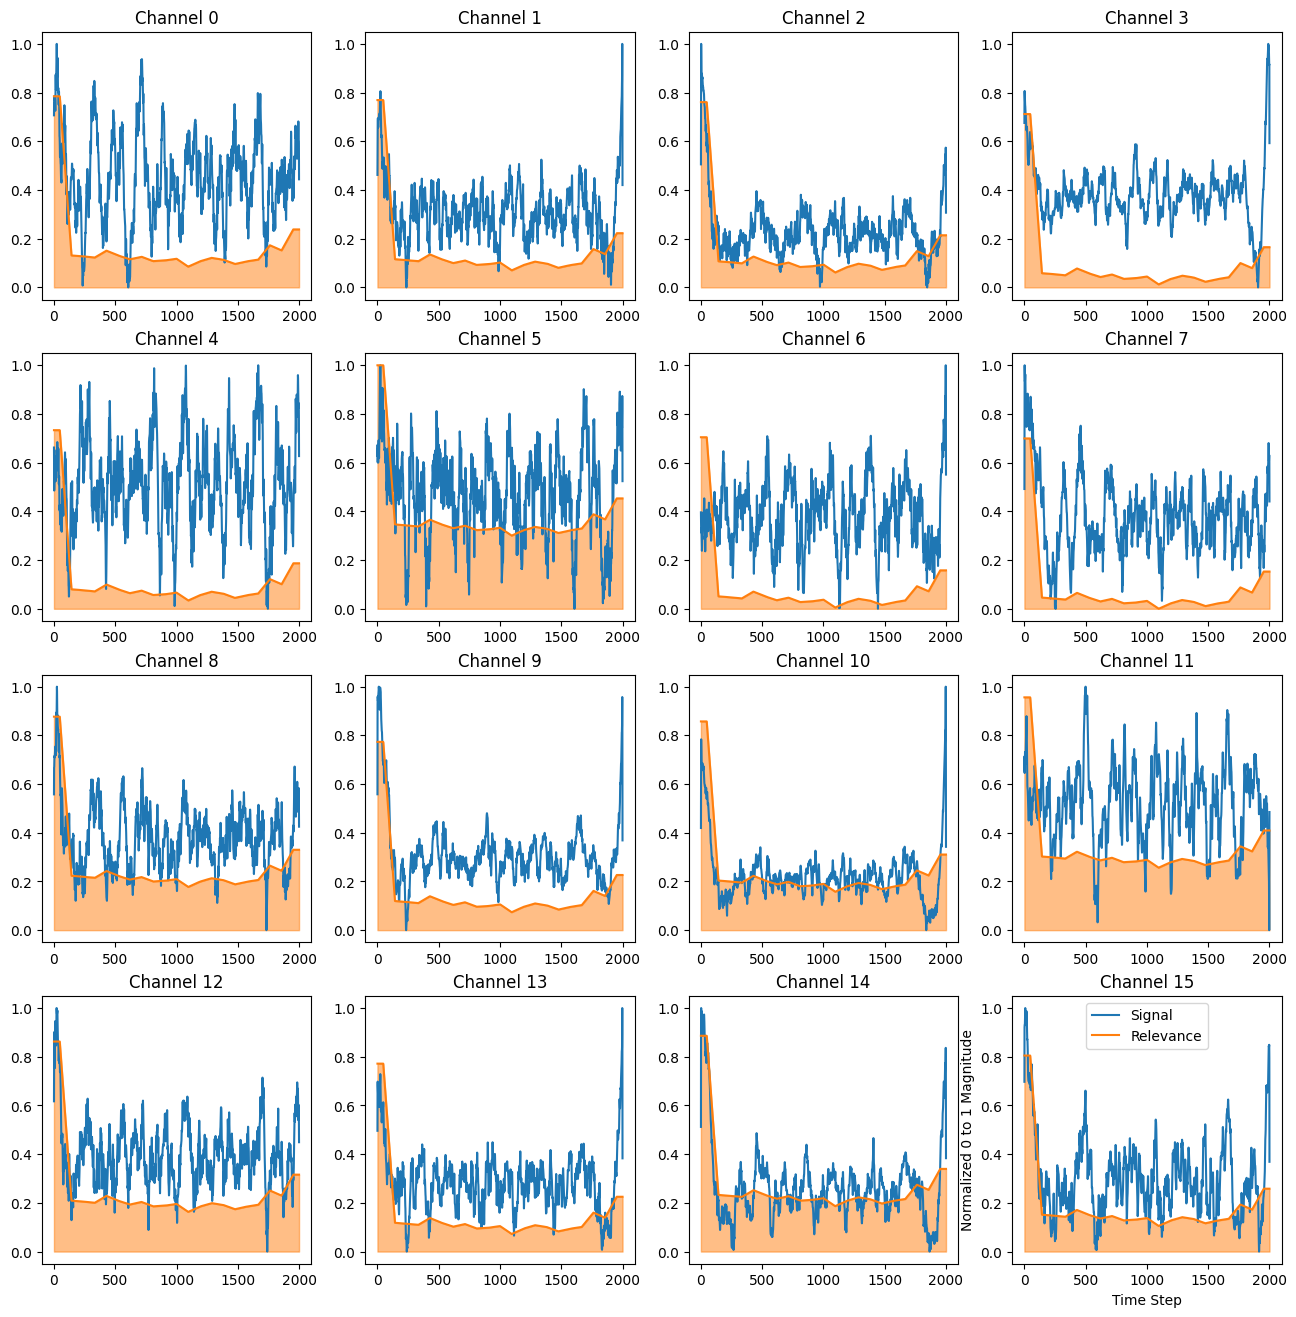

In [ ]:
# min-maxed scaled to 1
fig, ax = plt.subplots(4,4, figsize=(16,16))
ax = ax.flatten()
for channel_index in range(16):
    average_mask = (average_mask - average_mask.min()) / (average_mask.max() - average_mask.min())
    normalized_signal = (avg_tensor[channel_index,:] - avg_tensor[channel_index,:].min()) / (avg_tensor[channel_index,:].max() - avg_tensor[channel_index,:].min())
    ax[channel_index].plot(t, normalized_signal, c=categorical[0], label="Signal") # bad name, tensor is the signal we care about
    ax[channel_index].plot(t, average_mask[channel_index, :], c=categorical[1], label="Relevance")
    ax[channel_index].fill_between(t, 0, average_mask[channel_index,:], alpha=0.5, color=categorical[1])
    ax[channel_index].set_title("Channel " + str(channel_index))
plt.legend()
plt.ylabel("Normalized 0 to 1 Magnitude")
plt.xlabel("Time Step")
plt.savefig("fig/int/IIIC/Average_Channel_Attention_1D.png", bbox_inches='tight', pad_inches=0.0)

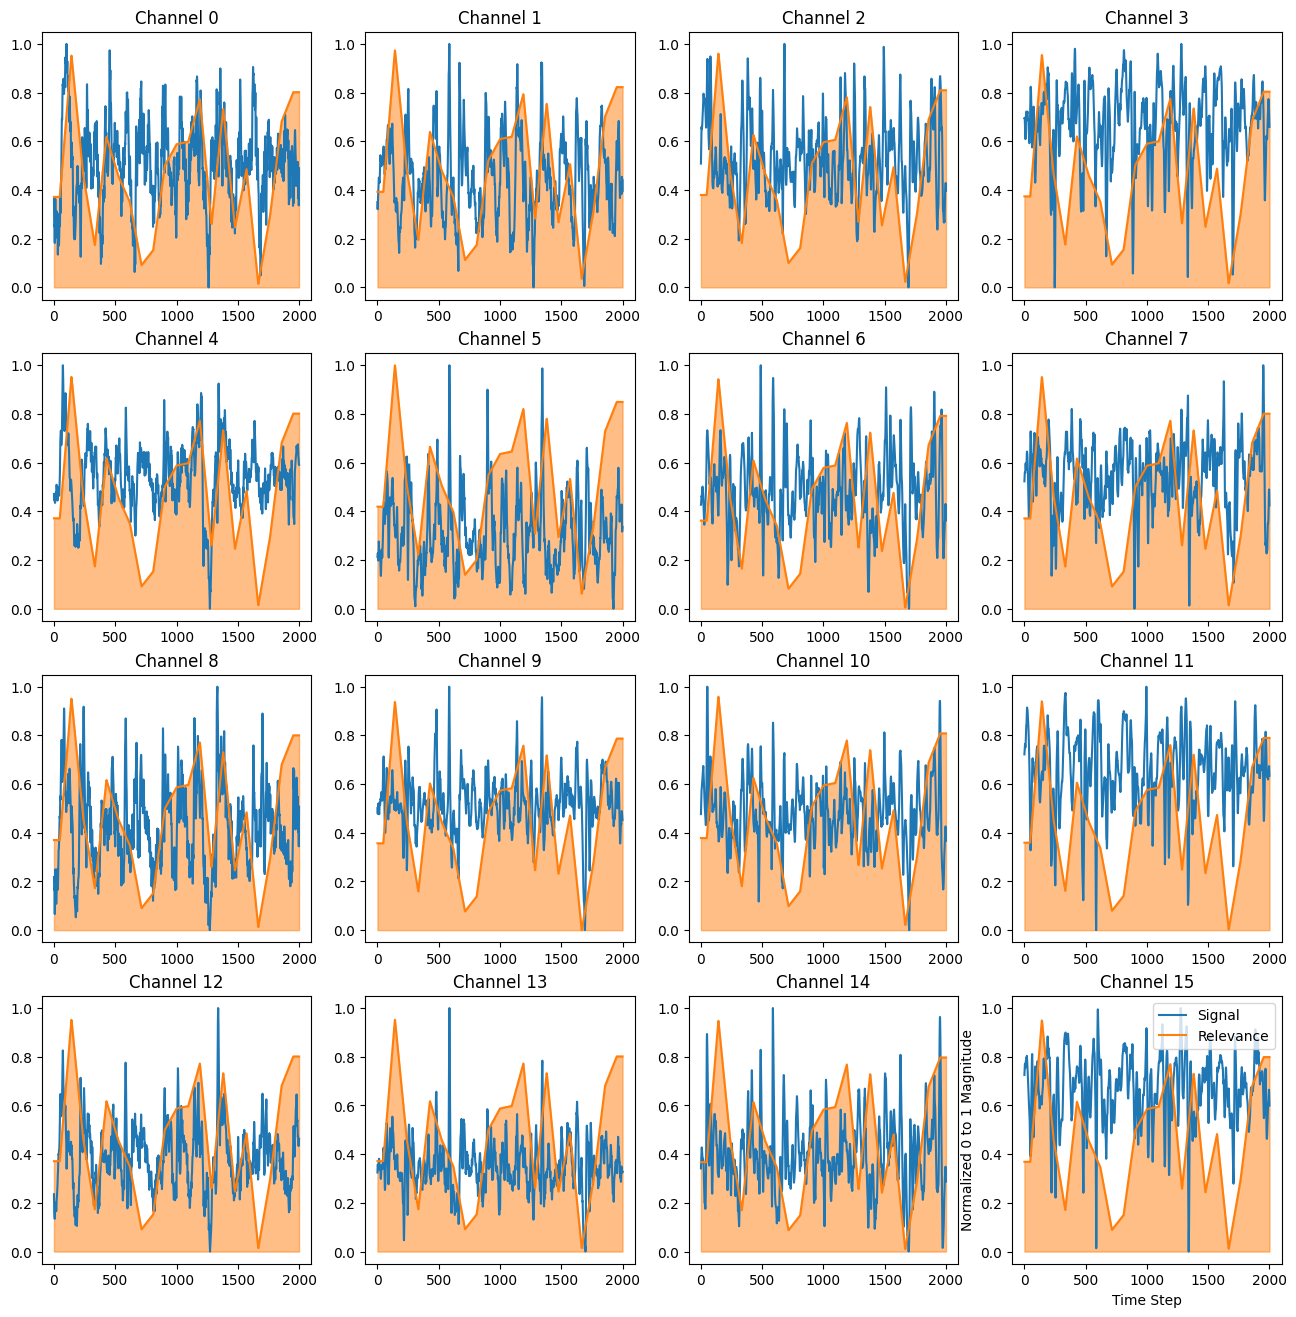

In [ ]:
fig, ax = plt.subplots(4,4, figsize=(16,16))
ax = ax.flatten()
sample_no = 0
mask = masks[sample_no]
signal = seizure_signals[sample_no]
for channel_index in range(16):
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    normalized_signal = (signal[channel_index,:] - signal[channel_index,:].min()) / (signal[channel_index,:].max() - signal[channel_index,:].min())
    ax[channel_index].plot(t, normalized_signal, c=categorical[0], label="Signal") # bad name, tensor is the signal we care about
    ax[channel_index].plot(t, mask[channel_index, :], c=categorical[1], label="Relevance")
    ax[channel_index].fill_between(t, 0, mask[channel_index,:], alpha=0.5, color=categorical[1])
    ax[channel_index].set_title("Channel " + str(channel_index))
plt.legend()
plt.ylabel("Normalized 0 to 1 Magnitude")
plt.xlabel("Time Step")
plt.savefig("fig/int/IIIC/1DChannel_Attention_Sample" +str(sample_no) +".png", bbox_inches='tight', pad_inches=0.0)

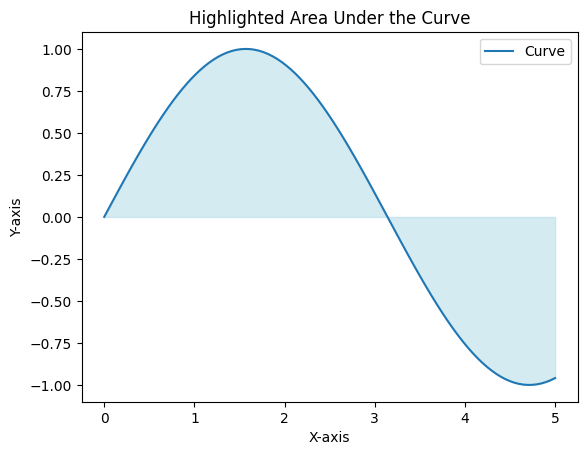

In [ ]:
x = np.linspace(0, 5, 100)
y = np.sin(x)  # Replace with your actual curve data

# Create the figure and axes
fig, ax = plt.subplots()

# Plot the curve
ax.plot(x, y, label='Curve')

# Fill the area under the curve with transparency
ax.fill_between(x, 0, y, alpha=0.5, color='lightblue')

# Add labels and legend (customize as needed)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Highlighted Area Under the Curve')
ax.legend()

# Show the plot
plt.show()